# Churn Reduction for Revolut Clients

The goal of this task is to understand the customers of Revolut, and aim to reduce the churn of users.

We consider that an unengaged user is a churned user. Thus to achieve our goal, we need to define metrics that enable us to classify engaged and unengaged users.

### Project plan :

*   [Part 2 : Target metric for engagement](#2)
  * [Initial understanding of Data](#I)
  * [Data preparation](#II)
  * [Data analysis](#III)
  * [User engagement metric](#IV)
  * [Engagement Analysis](#V)
*   [Part 3 : Classification model](#3)
  * [Data preparation](#data)
  * [Classification model](#ml)
     * [Logistic regression](#a)
     * [Support vector machines](#b)
     * [K-nearest neighbors](#c)
     * [Random forest](#d)
     * [Final model choice](#e)
*   [Part 4 : Churn reduction](#4)



---
#### <a name="2">**Part 2 :** *Define a target metric to measure engagement*</a>



We can push forward a hypothesis of defining engagement by classifying users through their engagement after receiving a notification.

We have observed that the number of transactions made by users in the 7 days after receiving a notification is different compared to the number of transactions made before receiving the notification.

We define engaged users in our hypothesis as users who made on average more transactions(at least by one) in the seven days after receiving a notification than the transactions made in the seven days before receiving a notification.

Unengaged users are then users who made on average same or less transactions in the seven days after receiving a notification than in the seven days before it.

We believe it is an accurate description of engaged and unengaged users, as in this case, the engaged users would be the ones that possibly react positively to notifications, and got an increasing engagement with time, opposite to unengaged and churned user that are slowly making less transactions with time, even after receiving notifications.

We will aim to confirm our hypothesis through an exploratory data analysis and study of our available data.

##### <a name="I">**I - Initial Understanding of Data**</a>
An exploration of the datasets used,  and their types of variables

We will start by importing the libraries we'll be using to manipulate data and for computing

In [ ]:
# Importing libraries
import pandas as pd 
import numpy as np

We will be then reading the data we'll be using, of transactions made by the users, notifications sent to users, information about those users and the brands of the phones of theirs

In [ ]:
# Reading user data
user_data = pd.read_csv("data/rev-users.csv") 

# Reading devices data
devices_data = pd.read_csv("data/rev-devices.csv") 

# Reading notifications data
notif_data = pd.read_csv("data/rev-notifications.csv") 

# Reading transaction data
transaction_data = pd.read_csv("data/rev-transactions.csv") 

A simple exploration of the all the data shows a lot of information about it. We would begin by exploring the user dataset : 

In [ ]:
print("Number of users : {:1d} user\nEach user defined by {:1d} variable".format(user_data.shape[0],user_data.shape[1]))

Number of users : 19430 user
Each user defined by 12 variable


In [ ]:
user_data.head()

,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,0,0
1,user_1,1975,GB,London,2018-01-29 03:38:46.676876,0,STANDARD,NaN,NaN,21,0,0
2,user_2,1987,PL,Poznań,2018-01-18 19:17:31.229096,0,STANDARD,0.0,0.0,21,0,0
3,user_3,1994,FR,Paris,2018-01-15 18:47:56.723104,0,STANDARD,1.0,0.0,0,0,0
4,user_4,1985,GB,Beckenham,2018-01-11 00:36:46.673673,0,STANDARD,NaN,NaN,2,0,0



We can see above the first five observations of our user data. The following are the variables we got about users : 
*   **user_id** : being the unique id of a Revolut user.
*   **birth_year** : the birth year of the user.
*   **country** : corresponding to the country of the user.
*   **city** : the city of residence of the user.
*   **created_date** : corresponding to the date when the user joined Revolut.
*   **user_settings_crypto_unlocked** : A value indicating if the user has activated crypto.
*   **plan** : A string indicating the plan the user chose for using the account.
*   **attributes_notifications_marketing_push** :  float indicating if the user has accepted to receive 
marketing push notifications.
*   **attributes_notifications_marketing_email** : float indicating if the user has accepted to receive 
marketing email notifications.
*   **num_contacts** : an integer showing the number of contacts the user got, that are also on Revolut.
*   **num_referrals** : The number of referred users by this same user.
*   **num_successful_referrals** : The numbers of referred users by this user that were successfully referred and became users.

We can have more details about each numerical variable :






In [ ]:
user_data.describe()

,birth_year,user_settings_crypto_unlocked,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals
count,19430.000000,19430.000000,12820.000000,12820.000000,19430.000000,19430.0,19430.0
mean,1983.648636,0.181009,0.947582,0.895944,17.887699,0.0,0.0
std,11.368871,0.385035,0.222877,0.305345,46.506438,0.0,0.0
min,1929.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,1978.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.0
50%,1986.000000,0.000000,1.000000,1.000000,5.000000,0.0,0.0
75%,1992.000000,0.000000,1.000000,1.000000,19.000000,0.0,0.0
max,2001.000000,1.000000,1.000000,1.000000,2918.000000,0.0,0.0


*   **birth_year** got values between a minimum of 1929 and a maximum of 2001. The ages of the users are between 19 years and 91 years, with the mean of age being 37 years ( a birth year of 1983).
*   **num_contacts** got values from users having zero contacts, to a maximum of 2918 contact on Revolut. The mean of number of contacts is 17, which means that most of the users got a very low number of contacts on Revolut.
*   **num_referrals** and **num_successful_referrals** appear to keep a value of zero throughout the dataset. This means that all users didn't refer a single person. 
We can see below a distribution of the frequency of the ages of the users :

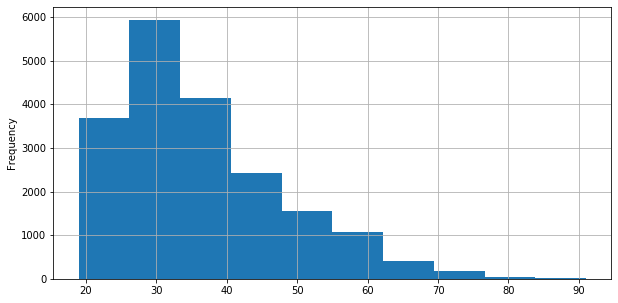

In [ ]:
# Plotting a histogram of the frequency of user ages, after computing the current age of each user
(2020 - user_data['birth_year']).plot(kind='hist',grid=True,figsize=(10,5))

Users appear to be the most frequent between 19 and 41 years, and then slowly going down in frequency.

We will below make a count of occurences of the categorical variables in our dataset. We will begin by whether users have activated crypto on their account.

In [ ]:
# Counting the occurence of each value in the crypto variable 
user_data['user_settings_crypto_unlocked'].value_counts()

0    15913
1     3517
Name: user_settings_crypto_unlocked, dtype: int64

We observe that the majority of users (15913 user) didn't activate crypto on their account, with only a group (3517 user) activating it.

Below is a study of occurences in the country variables :

In [ ]:
# counting the occurences of each country in the user database 
user_data['country'].value_counts()

GB    6315
PL    2306
FR    2110
IE    1214
RO    1096
ES     991
LT     646
PT     604
MT     548
DE     446
CH     443
CZ     355
IT     311
GR     218
CY     191
NL     174
LV     171
HU     157
BE     143
SE     141
DK     101
BG      94
NO      87
SI      87
SK      79
AT      78
HR      63
JE      55
GI      44
FI      38
EE      35
LU      24
GG      15
IM      11
GP      10
RE       7
IS       7
AU       6
MQ       4
LI       4
GF       1
Name: country, dtype: int64

We can thus find that while some countries have very numerous observations, a few others got extremely few observations.

We can have more details about the data below :


In [ ]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19430 entries, 0 to 19429
Data columns (total 12 columns):
user_id                                     19430 non-null object
birth_year                                  19430 non-null int64
country                                     19430 non-null object
city                                        19430 non-null object
created_date                                19430 non-null object
user_settings_crypto_unlocked               19430 non-null int64
plan                                        19430 non-null object
attributes_notifications_marketing_push     12820 non-null float64
attributes_notifications_marketing_email    12820 non-null float64
num_contacts                                19430 non-null int64
num_referrals                               19430 non-null int64
num_successful_referrals                    19430 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 1.8+ MB


It appears that **attributes_notifications_marketing_push** and **attributes_notifications_marketing_email** got many missing values.

We will now explore the devices dataset :

In [ ]:
print("Number of devices : {:1d} device\nEach device defined by {:1d} variable".format(devices_data.shape[0],devices_data.shape[1]))

Number of devices : 19430 device
Each device defined by 2 variable


In [ ]:
devices_data.head()

,brand,user_id
0,Android,user_3257
1,Apple,user_6809
2,Android,user_9144
3,Apple,user_3636
4,Android,user_5970


- **brand** : string corresponding to the phone brand.
- **user_id** : string uniquely identifying the user.

A quick study of the occurences in the brand shows the following :

In [ ]:
# count of occurences of values of the device brands
devices_data['brand'].value_counts()

Android    9714
Apple      9673
Unknown      43
Name: brand, dtype: int64

We have 'Android' and 'Apple' as brands, with a few having an 'Unknown' brand.

We will now explore the notifications data as follow :

In [ ]:
print("Number of notifications : {:1d} notification\nEach notification defined by {:1d} variable".format(notif_data.shape[0],notif_data.shape[1]))

Number of notifications : 121813 notification
Each notification defined by 5 variable


In [ ]:
notif_data.head()

,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6598,2018-12-01 23:09:37.367127
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_4151,2018-12-04 02:57:56.425660
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_1408,2018-12-11 02:04:46.284683
4,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6292,2018-12-14 17:09:58.900808


The view above of the five first observations shows that each notification is defined by five variables :

- **reason** : A string indicating the reason for which the notification was sent.
- **channel** : A string indicating the way the user has been notified of the notification.
- **status** : A string indicating whether the notification was successfully sent or failed.
- **user_id** : a unique id defining each user.
- **created_date** : The creation date and time of the notification.

Below are the list of reasons a user could receive a notification :

In [ ]:
notif_data['reason'].unique()

array(['REENGAGEMENT_ACTIVE_FUNDS', 'PUMPKIN_PAYMENT_NOTIFICATION',
       'NO_INITIAL_CARD_USE', 'ENGAGEMENT_SPLIT_BILL_RESTAURANT',
       'METAL_RESERVE_PLAN', 'ONBOARDING_TIPS_ACTIVATED_USERS',
       'MADE_MONEY_REQUEST_NOT_SPLIT_BILL',
       'PREMIUM_ENGAGEMENT_INACTIVE_CARD', 'NO_INITIAL_CARD_ORDER',
       'PREMIUM_ENGAGEMENT_FEES_SAVED', 'FIFTH_PAYMENT_PROMO',
       'WELCOME_HOME', 'NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER',
       'LOST_CARD_ORDER', 'BLACK_FRIDAY', 'METAL_GAME_START',
       'JOINING_ANNIVERSARY'], dtype=object)

Below the distribution of the different status of a notification in our dataset :

In [ ]:
notif_data['status'].value_counts()

SENT      89477
FAILED    32336
Name: status, dtype: int64


32.336 notification have failed reaching the users, while 89.477 have reached users successfully.

We then make an exploration of the transaction dataset : 



In [ ]:
print("Number of transactions : {:1d} transaction\nEach transaction defined by {:1d} variable".format(transaction_data.shape[0],transaction_data.shape[1]))

Number of transactions : 2740075 transaction
Each transaction defined by 12 variable


In [ ]:
transaction_data.head()

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_0,TRANSFER,AED,4.55,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_898,2018-04-03 03:34:21.784487
1,transaction_1,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,4111.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-19 06:15:59.537032
2,transaction_2,CARD_PAYMENT,AED,43.40,COMPLETED,FALSE,5814.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-18 18:53:41.323032
3,transaction_3,TRANSFER,AED,10043.01,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_1652,2019-03-22 14:20:01.513032
4,transaction_4,CARD_PAYMENT,AED,43.81,COMPLETED,FALSE,5651.0,Abu Dhabi,ARE,OUTBOUND,user_5509,2019-03-22 05:42:50.316652


Above are the first five observations of the transaction dataset. They are defined by the following variables : 
-  **transaction_id** : a string uniquely identifying the transaction.
-  **transactions_type** : string indicating the type of the transaction.
-  **transactions_currency** : string indicating the currency of the transaction.
-  **amount_usd** : float corresponding to the transaction amount in USD.
-  **transactions_state** : the state of the transaction, whether successful, reverted or declined.
-  **ea_cardholderpresence** : string indicating if the card holder was present when the transaction happened.
-  **ea_merchant_mcc** : float corresponding to the Merchant Category Code.
-  **ea_merchant_city** : string corresponding to the merchant’s city.
-  **ea_merchant_country** : string corresponding to the merchant’s country.
-  **direction** : String indicating whether the money went into or out of the account.
-  **created_date** : datetime of the transaction.
-  **user_id** : unique id of the user making the transaction.

A count of the missing values in this dataset : 



In [ ]:
# number of missing values in each variable
transaction_data.isnull().sum()

transaction_id                 0
transactions_type              0
transactions_currency          0
amount_usd                     0
transactions_state             0
ea_cardholderpresence    1170594
ea_merchant_mcc          1158658
ea_merchant_city         1158794
ea_merchant_country      1158979
direction                      0
user_id                        0
created_date                   0
dtype: int64

The missing values are mostly located in the merchant information.


##### <a name="II">**II - Data preparation**</a>

The data we just explored will have to be prepared, in order to create user profiles and their measure of engagement.

To do that, we'll have to count first the number of transactions each user does after each notification by 7 days and before it by 7 days, then the average difference between his transactions before and after notifications for each user.

Then we will specify a metric for engagement that separates the engaged and the unengaged through that difference.


To start working on that, we would first need to perform a cleanup on the notification data. We are aiming to see whether users perform more transactions after receiving a notification than before it. That would mean that we shouldn't include notifications that are results of a transaction or payment, as they aren't notifications aimed toward making the user more engaged.

*PUMPKIN_PAYMENT_NOTIFICATION* and *MADE_MONEY_REQUEST_NOT_SPLIT_BILL* appear to be notifications that are results of user transactions. We will then drop them, in order to not have mixed information about the behaviour after notifications in our engagement scores.

In [ ]:
# Deleting notifications that are results of payments/transactions 
notif_data = notif_data[notif_data['reason'] != 'PUMPKIN_PAYMENT_NOTIFICATION']
notif_data = notif_data[notif_data['reason'] != 'MADE_MONEY_REQUEST_NOT_SPLIT_BILL']

We also wish to explore and take out the notifications that intersect in periods of time. 

If a second notification happens a day or two after the first notification for the same user, the results of both notifications would not be accurate because of the mixup. That is the reason we would filter all these notifications and drop them out of the notification dataset.

We will then as follow first find the notifications that intersect in time periods (7 days before each notification and 7 days after it).

In [ ]:
# Performing an inner join for the notification data with itself, 
# to filter notifications that intersect in time later on
merged_notifs = pd.merge(notif_data,notif_data,how='inner',on='user_id')

# Setting up the time periods for each notification where there shouldn't exist another notification 
# 14 days are added before and after, to factor the time periods of both notifications
merged_notifs['before_date'] = (merged_notifs['created_date_x'].values.astype('datetime64[ms]') - np.timedelta64(14,'D'))
merged_notifs['after_date'] = (merged_notifs['created_date_x'].values.astype('datetime64[ms]') + np.timedelta64(14,'D'))

# We filter the pair of notifications by notification dates, in order to not have the same notification with itself
merged_notifs = merged_notifs[merged_notifs['created_date_x']!=merged_notifs['created_date_y']]

# Next is filtering the joined pairs to only keep the intersections of "sent" notifications
merged_notifs = merged_notifs[merged_notifs['status_x']== 'SENT']
merged_notifs = merged_notifs[merged_notifs['status_y']== 'SENT']

# The next filter is to keep only intersecting pairs of notifications, and drop out the non intersecting ones
merged_notifs = merged_notifs[merged_notifs['after_date']>merged_notifs['created_date_y'].values.astype('datetime64[ms]')]
merged_notifs = merged_notifs[merged_notifs['before_date']<merged_notifs['created_date_y'].values.astype('datetime64[ms]')]

# Then setting the column titles back to their initial values
merged_notifs['created_date'] = merged_notifs['created_date_x']
merged_notifs['reason'] = merged_notifs['reason_x']
merged_notifs['channel'] = merged_notifs['channel_x']
merged_notifs['status'] = merged_notifs['status_x']
merged_notifs = merged_notifs[['reason','channel','status','user_id','created_date']]

# Dropping duplicates and resetting the index of the results
merged_notifs = merged_notifs.drop_duplicates().reset_index()[['reason','channel','status','user_id','created_date']]


We can see below some observations and informations about all intersecting notifications we got, that we will have to drop out to keep the results of our study correct without mixed up information.

In [ ]:
print("Number of intersecting notifications : {:1d} notification".format(merged_notifs.shape[0]))

Number of intersecting notifications : 44231 notification


In [ ]:
merged_notifs.head()

,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-27 17:59:46.786645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-21 18:03:53.943645
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2019-01-23 18:06:10.731645
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2019-01-11 17:59:44.400645
4,FIFTH_PAYMENT_PROMO,PUSH,SENT,user_7086,2019-01-17 19:42:48.432645


We will then delete these notifications from our initial notification dataset.

In [ ]:
# We will perform a left join between the initial notification data (left) and the intersecting notifications (right)
merged_notif_null = pd.merge(notif_data,merged_notifs,how='left',on='created_date')

# in the resulting dataframe, all data that is an intersection notification will have no missing values 
# as it would be an intersection between the two earlier dataframes, so we will only keep the notifications that got missing values
merged_notif_null = merged_notif_null[merged_notif_null['reason_y'].isnull()].reset_index()

# Fixing the column titles 
merged_notif_null['user_id'] = merged_notif_null['user_id_x']
merged_notif_null['reason'] = merged_notif_null['reason_x']
merged_notif_null['channel'] = merged_notif_null['channel_x']
merged_notif_null['status'] = merged_notif_null['status_x']
merged_notif_null = merged_notif_null[['reason','channel','status','user_id','created_date']]

# Filtering the notifications we have left, in order to use only the sent notifications
sent_notifs = merged_notif_null[merged_notif_null['status'] == "SENT"]


The remaining notifications we'll then be using throughout the following analysis are as follow :

In [ ]:
print("Number of final notifications we'll be using : {:1d} notification".format(sent_notifs.shape[0]))

Number of final notifications we'll be using : 43077 notification


In [ ]:
sent_notifs.head()

,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_4151,2018-12-04 02:57:56.425660
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_1408,2018-12-11 02:04:46.284683
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6292,2018-12-14 17:09:58.900808
4,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_4098,2018-12-11 12:42:59.718574


We will now count the number of transactions 7 days before each notification, and 7 days after each notification, using the notifications we have filtered.

In [ ]:
# Setting up the dates before and after each notifications, where the count will hold
sent_notifs['before_date'] = (sent_notifs['created_date'].values.astype('datetime64[ms]') - np.timedelta64(7,'D'))
sent_notifs['after_date'] = (sent_notifs['created_date'].values.astype('datetime64[ms]') + np.timedelta64(7,'D'))

# Performing an inner join between the notifications and transactions with the same user_id
notif_transaction_join = pd.merge(sent_notifs, transaction_data, how='inner',on='user_id')

# Filtering the transactions and notification merged data, to keep only transactions that happened 7 days before or 7 days after a notification
notif_transaction_join = notif_transaction_join[(notif_transaction_join.created_date_y.values.astype('datetime64[ms]') > notif_transaction_join.before_date) & (notif_transaction_join.created_date_y.values.astype('datetime64[ms]') < notif_transaction_join.after_date)]

# Preparing dates for further operations
notif_transaction_join['notification_date'] = (notif_transaction_join['created_date_x'].values.astype('datetime64[ms]'))
notif_transaction_join['transaction_date'] = (notif_transaction_join['created_date_y'].values.astype('datetime64[ms]'))

After creating a table of notifications joined with transactions in the same periods of time, we will define some helper functions that will help us find the number of transactions before and after the notifications.

In [ ]:
# Returns boolean if the transaction happened in the 7 days after the notification
def after_f(row):
    if row['transaction_date'] >= row['before_date'] and row['transaction_date'] <= row['notification_date']:
        val = 0
    elif row['transaction_date'] <= row['after_date'] and row['transaction_date'] > row['notification_date']:
        val = 1
    else:
        val = 0
    return val

# Returns boolean if the transaction happened in the 7 days before the notification
def before_f(row):
    if row['transaction_date'] >= row['before_date'] and row['transaction_date'] <= row['notification_date']:
        val = 1
    elif row['transaction_date'] <= row['after_date'] and row['transaction_date'] > row['notification_date']:
        val = 0
    else:
        val = 0
    return val

# returns the sum of dataframe columns
def sum_counts(df, col, new_col,second_col,new_s_col):
    df[new_col] = df[col].sum()
    df[new_s_col] = df[second_col].sum()
    return df

We then count the number of transactions 7 days before and 7 days after each notification for the same user :

In [ ]:
# Creating columns of booleans for whether a transaction was in the before or after time period of a notification
notif_transaction_join['after_bool'] = notif_transaction_join.apply(after_f, axis=1)
notif_transaction_join['before_bool'] = notif_transaction_join.apply(before_f, axis=1)

# Calculating the total number of transactions before and after in the time period of each notification
notif_transaction_join = notif_transaction_join.groupby(['user_id','notification_date']).apply(sum_counts,'after_bool','count_after','before_bool','count_before')

# Computing the difference between number of transactions before and after each notification
notifications = notif_transaction_join[['user_id','notification_date','reason','channel','count_before','count_after']]
notifications['difference'] = (notifications['count_after'] - notifications['count_before'])

# Dropping duplicates and reseting the index
notifications = notifications.drop_duplicates().reset_index()[['user_id','notification_date','reason','channel','count_before','count_after','difference']]

As a result, we have all notifications that had transactions in their time periods, with the count of those transactions as follow :

In [ ]:
notifications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21941 entries, 0 to 21940
Data columns (total 7 columns):
user_id              21941 non-null object
notification_date    21941 non-null datetime64[ns]
reason               21941 non-null object
channel              21941 non-null object
count_before         21941 non-null int64
count_after          21941 non-null int64
difference           21941 non-null int64
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 1.2+ MB


We now need to add the notifications that didn't have any transactions in their time periods to our dataframe, with their difference in transactions being 0.

In [ ]:
# Merging all sent notifications with our count of notifications, using a left join
temp_notifs = sent_notifs.merge(notifications,how='left',on='user_id')

# taking only the rows with missing values in the difference column, which means that they do are not in the intersection of the two dataframes
temp_notifs = temp_notifs[temp_notifs['difference'].isnull()][['user_id','created_date','reason_x','channel_x','count_before','count_after','difference']]

# We fill all difference NA values with values of 0, as these notifications had no transactions whether before or after the notification date
temp_notifs = temp_notifs.fillna(0)

# Setting up the data properly
temp_notifs['notification_date'] = (temp_notifs['created_date'].values.astype('datetime64[ms]'))
temp_notifs['channel'] = temp_notifs['channel_x']
temp_notifs['reason'] = temp_notifs['reason_x']

# Reseting the index
temp_notifs = temp_notifs.reset_index()[['user_id','notification_date','reason','channel','count_before','count_after','difference']]

# Concatenating the two dataframes, to have all the sent notifications with their count and difference in transactions
notifications = pd.concat([notifications,temp_notifs])

# Reseting the index
notifications = notifications.reset_index()[['user_id','notification_date','reason','channel','count_before','count_after','difference']]


As a result, we have all the notifications, with the difference between the number of transactions before it and after it by 7 days. 

In [ ]:
print("Number of notifications  : {:1d} notification".format(notifications.shape[0]))

Number of notifications  : 31546 notification


In [ ]:
notifications.head()

,user_id,notification_date,reason,channel,count_before,count_after,difference
0,user_7086,2018-12-02 17:58:33.320,REENGAGEMENT_ACTIVE_FUNDS,PUSH,1.0,2.0,1.0
1,user_7086,2018-11-17 18:12:38.112,REENGAGEMENT_ACTIVE_FUNDS,PUSH,2.0,1.0,-1.0
2,user_4151,2018-10-25 02:05:30.995,REENGAGEMENT_ACTIVE_FUNDS,PUSH,0.0,6.0,6.0
3,user_4151,2019-05-02 22:28:06.935,JOINING_ANNIVERSARY,PUSH,0.0,1.0,1.0
4,user_1408,2018-11-11 02:03:46.791,REENGAGEMENT_ACTIVE_FUNDS,PUSH,2.0,0.0,-2.0


We will afterward compute the average difference for each user, as each user might have many notifications. 

To achieve that, we will define the following helper function :

In [ ]:
def diff_mean(df, col, new_col):
    df[new_col] = df[col].mean()
    return df

Then we will compute the mean difference :

In [ ]:
# grouping notifications by user id, and computing their mean
notifs = notifications.groupby('user_id').apply(diff_mean,'difference','avg_diff')

# droping duplicates and reseting index
notifs = notifs[['user_id','avg_diff']].drop_duplicates().reset_index()[['user_id','avg_diff']]

In [ ]:
print("Number of users  : {:1d} user".format(notifs.shape[0]))

Number of users  : 16855 user


We will now work on the user dataset, in order to merge it with the notification dataset. We will first need to deal with the missing values on the user data :

In [ ]:
user_data.isnull().sum()

user_id                                        0
birth_year                                     0
country                                        0
city                                           0
created_date                                   0
user_settings_crypto_unlocked                  0
plan                                           0
attributes_notifications_marketing_push     6610
attributes_notifications_marketing_email    6610
num_contacts                                   0
num_referrals                                  0
num_successful_referrals                       0
dtype: int64

The variables **attributes_notifications_marketing_push** and **attributes_notifications_marketing_email** have numerous missing values.

We will aim to deal with these missing values. These attributes show whether the user accepted to receive notifications. Our approach to deal with them, is to check if a user received a notification before. In the case he did, these missing values would have the value of 1, if not then 0.

In [ ]:
# filtering to have only sent notifications
n_user = notif_data[notif_data['status'] == 'SENT']

# merging user data with notification data using a left join
joined = pd.merge(user_data, n_user, how='left',on='user_id')

We will now define a helper function to count the number of notifications each user received, so that we fill missing values using that information :

In [ ]:
def count_col(df, col, new_col):
    df[new_col] = df[col].count()
    return df

In [ ]:
# grouping merged data by user id and counting the number of notifications each user received
grouped = joined.groupby('user_id').apply(count_col,'status','channel_count')

# Looping over the user data, to replace missing data with 1 if user received a notification before
for index,row in grouped.iterrows() :
    if  grouped.at[index,'channel_count']>0 and row['attributes_notifications_marketing_email'] != 0 :
        grouped.at[index,'attributes_notifications_marketing_email'] = 1.0
    if  grouped.at[index,'channel_count']>0 and row['attributes_notifications_marketing_push'] != 0:
        grouped.at[index,'attributes_notifications_marketing_push'] = 1.0


# dropping the extremely few NA values left
grouped_na = grouped.dropna()

# resetting index and dropping duplicates
users = grouped_na[['user_id','birth_year','country','city','created_date_x','user_settings_crypto_unlocked','plan','attributes_notifications_marketing_push','attributes_notifications_marketing_email','num_contacts','num_referrals','num_successful_referrals']]
users = users.drop_duplicates().reset_index()[['user_id','birth_year','country','city','created_date_x','user_settings_crypto_unlocked','plan','attributes_notifications_marketing_push','attributes_notifications_marketing_email','num_contacts','num_referrals','num_successful_referrals']]

We will then set out to merge the user data with the average difference of transactions in notification periods for each user.

In [ ]:
# an inner join between the data of users, and the aggregated data from notifications, on the user id
engagement_temp = pd.merge(users, notifs, how='inner',on='user_id')

Afterward we will merge the data of the devices used by each user, with out current dataset. A first step toward that would be to prepare the devices dataset properly.





In [ ]:
devices_data['brand'].value_counts()

Android    9714
Apple      9673
Unknown      43
Name: brand, dtype: int64

As we can notice, the devices used by users are divided between Android devices and Apple devices. A few devices seem to not have been recognized, and have been entered as unknown. A safe deduction we can make is that the devices would be Android devices, or derivatives, as Apple devices would always be recognized.

In [ ]:
# replacing the 'Unknown' data by 'Android'
devices_data['brand'] = devices_data['brand'].str.replace("Unknown", "Android")

We would then merge the devices data with our dataset we have been preparing.

In [ ]:
# creating the engagement dataset
engagement = pd.merge(engagement_temp, devices_data, how='inner',on='user_id')

Through this, we have created a dataset that we will be using to set a metric of engagement. A quick exploration of the dataset would show us this : 

In [ ]:
print("Number of user : {:1d} user\nEach user defined by {:1d} variable".format(engagement.shape[0],engagement.shape[1]))

Number of user : 16855 user
Each user defined by 14 variable


Our next step would be to do an exploration on the variables of our dataset, in order to find out all the possible transformations we could make on its variables, to better define engagement metrics.

In [ ]:
engagement.head()

,user_id,birth_year,country,city,created_date_x,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,avg_diff,brand
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,0,0,4.333333,Apple
1,user_1,1975,GB,London,2018-01-29 03:38:46.676876,0,STANDARD,1.0,1.0,21,0,0,5.000000,Apple
2,user_5,1993,LT,Vilnius,2018-01-04 17:45:03.907804,1,STANDARD,1.0,1.0,0,0,0,0.000000,Apple
3,user_6,1978,GB,Brighton,2018-01-24 19:04:50.876183,0,STANDARD,1.0,1.0,0,0,0,0.000000,Apple
4,user_7,1989,RO,Bucharest,2018-01-11 19:11:45.757486,0,STANDARD,1.0,1.0,0,0,0,0.000000,Apple


In [ ]:
print("Number of different cities in dataset : {:1d} city".format(len(engagement['city'].unique())))

Number of different cities in dataset : 5475 city


The number of city categories in our dataset appears to be very high, while the countries would have the same amount of information with much less categories, which would help us generalize our analysis and future models better. Thus, we will drop the city variable.

In [ ]:
# Dropping the city variable from the dataset
engagement = engagement.drop('city',axis=1)

We will now analyze the relationship of the **num_contacts** variables with the average difference.

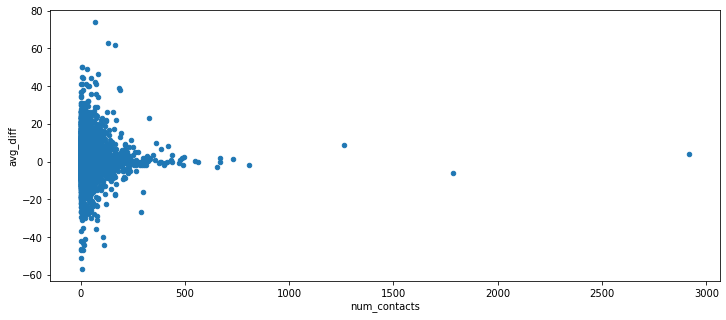

In [ ]:
engagement.plot(x='num_contacts',y='avg_diff',kind='scatter',figsize=(12,5))

There appears to be no relationship between the two variables. We will then drop the **num_contacts** variable.

In [ ]:
# Dropping the city variable from the dataset
engagement = engagement.drop('num_contacts',axis=1)

We will next have a look at our dataset :

In [ ]:
engagement.describe()

,birth_year,user_settings_crypto_unlocked,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_referrals,num_successful_referrals,avg_diff
count,16855.000000,16855.000000,16855.000000,16855.000000,16855.0,16855.0,16855.000000
mean,1983.596084,0.185998,0.979650,0.946069,0.0,0.0,0.861822
std,11.351729,0.389117,0.141199,0.225887,0.0,0.0,5.170807
min,1929.000000,0.000000,0.000000,0.000000,0.0,0.0,-57.000000
25%,1977.000000,0.000000,1.000000,1.000000,0.0,0.0,-0.500000
50%,1986.000000,0.000000,1.000000,1.000000,0.0,0.0,0.000000
75%,1992.000000,0.000000,1.000000,1.000000,0.0,0.0,2.000000
max,2001.000000,1.000000,1.000000,1.000000,0.0,0.0,74.000000


It clearly appears that the **num_referrals** and **num_successful_referrals** keep having a value of zero in all the dataset. That means they have no effect on the average difference, and so they will also be dropped.

In [ ]:
# dropping irrelevant data
engagement = engagement.drop('num_referrals',axis=1)
engagement = engagement.drop('num_successful_referrals',axis=1)

Next, we would be working on the **birth_year** variable, to transform it into categories of age groups. After we have explored the distributions of ages in the beginning, we'll begin by defining a helping function, that divides age groups into the following : '18 - 27', '27 - 31', '31 - 36', '36 - 45', '53 +'

In [ ]:
# converting birth years to categories of ages
def birth_to_cat(row):
  age = 2020 - row['birth_year']
  if age >= 18 and age < 27 :
    val = '18 - 27'
  elif age >= 27 and age < 31 :
    val = '27 - 31'
  elif age >= 31 and age < 36 :
    val = '31 - 36'
  elif age >= 36 and age < 45 :
    val = '36 - 45'
  elif age >= 45 and age < 53 :
    val = '45 - 53'
  else:
    val = '53 +'
  return val

We will then transform the birth_years into age groups and categories :

In [ ]:
# creating age groups
engagement['age'] = engagement.apply(birth_to_cat,axis=1)

Our next step would be working on the **created_date** of each user of our dataset, which means his joining date to Revolut. We aim to convert it into categories of ancientness as a Revolut Bank user. We will begin by importing a necessary library and changing the type of the variable :

In [ ]:
# importing datetime for date manipulations
import datetime

# creating a joining date column with a Day type 
engagement['joining_date'] = (engagement['created_date_x'].values.astype('datetime64[D]') )

We then define helper functions to find the ancientness :

In [ ]:
# transforming joining date to ancientness by days
def ancientness(row):
    val = np.datetime64(datetime.datetime.now()).astype('datetime64[D]') - np.datetime64(row['joining_date']).astype('datetime64[D]')
    return val

# converting the ancientness by days to categories of ancientness by months
def months_ancientness(row):
  months = int(row['int_ancient'] / 30)
  if months >= 12 and months < 14 :
    val = '12-14'
  elif months >= 14 and months < 16:
    val = '14-16'
  elif months >= 16 and months < 18:
    val = '16-18'
  elif months >= 18 and months < 20:
    val = '18-20'
  elif months >= 20 and months < 22:
    val = '20-22'
  elif months >= 22 and months < 24:
    val = '22-24'
  elif months >= 24:
    val = '24+'
  return val

We create afterward categories of ancientness, by periods of two months :

In [ ]:
# finding ancientness of each user in terms of days
engagement['ancientness'] = engagement.apply(ancientness, axis=1)

# converting the ancientness to int (days)
engagement['int_ancient'] = engagement['ancientness'].astype(int) / (3600*24*1000000000)

# setting up categories of ancientness by months
engagement['ancientness'] = engagement.apply(months_ancientness,axis=1)

# leaving only relevant columns
engagement = engagement[['user_id','country','age','user_settings_crypto_unlocked','plan','attributes_notifications_marketing_push','attributes_notifications_marketing_email','brand','ancientness','avg_diff']]

The distribution of the ancientness categories appears to be evenly distributed as follow :

In [ ]:
# the number of occurences of the values of ancientness
engagement['ancientness'].value_counts()

16-18    3034
18-20    3011
14-16    2970
24+      2840
20-22    2783
22-24    2217
Name: ancientness, dtype: int64

A peak at out resulting dataset show us the first five observations :

In [ ]:
engagement.head()

,user_id,country,age,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,brand,ancientness,avg_diff
0,user_0,PL,31 - 36,1,STANDARD,1.0,1.0,Apple,24+,4.333333
1,user_1,GB,45 - 53,0,STANDARD,1.0,1.0,Apple,24+,5.000000
2,user_5,LT,27 - 31,1,STANDARD,1.0,1.0,Apple,24+,0.000000
3,user_6,GB,36 - 45,0,STANDARD,1.0,1.0,Apple,24+,0.000000
4,user_7,RO,31 - 36,0,STANDARD,1.0,1.0,Apple,24+,0.000000


We will be saving the dataset, to be using it in other parts.

In [ ]:
# saving dataset as a csv
engagement.to_csv('data/rev-engagement.csv')



---
##### <a name="III">**III - Data Analysis**</a>
We will analyze the variables and their correlation with the average difference in transactions in time periods of notifications, with an univariate and bivariate analysis, to find out whether our engagement metric can be extrapolated from it.

We will start by importing our previously prepared engagement dataset

In [ ]:
# reading previously prepared engagement data
engagement = pd.read_csv('data/rev-engagement.csv').drop('Unnamed: 0',axis=1)

We will begind to explore the relationships of the variables with the average difference. We would first define a helper function to help up compute the mean average difference for every category of our variables : 

In [ ]:
# compute the mean of a column
def mean_col(df, col, new_col):
    df[new_col] = df[col].mean()
    return df

Afterward, we'll explore how the different countries affect the mean difference in transactions :

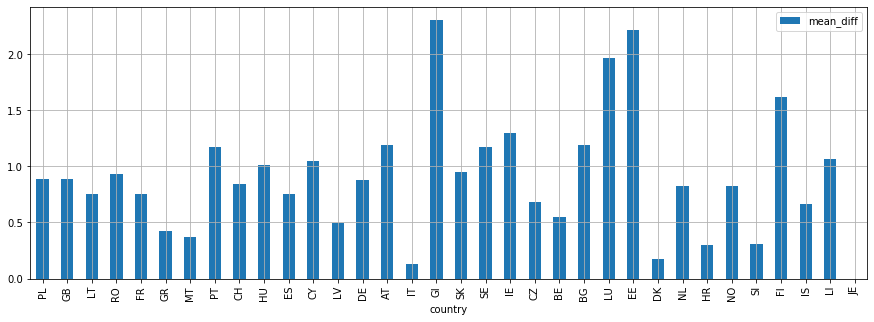

In [ ]:
# computing the mean difference for all the countries
countries = engagement.groupby('country').apply(mean_col,'avg_diff','mean_diff')[['country','mean_diff']].copy().drop_duplicates()

# a bar plot of the mean difference in each country
countries.plot.bar(x='country',y='mean_diff',figsize=(15,5),grid=True)

We observe that all countries have a superior mean difference to zero, but only a few of them have an average of one more transaction after each notification (mean difference superior to 1), which means some countries got a far superior engagement than other countries.

An exploration of the age variable shows the following :

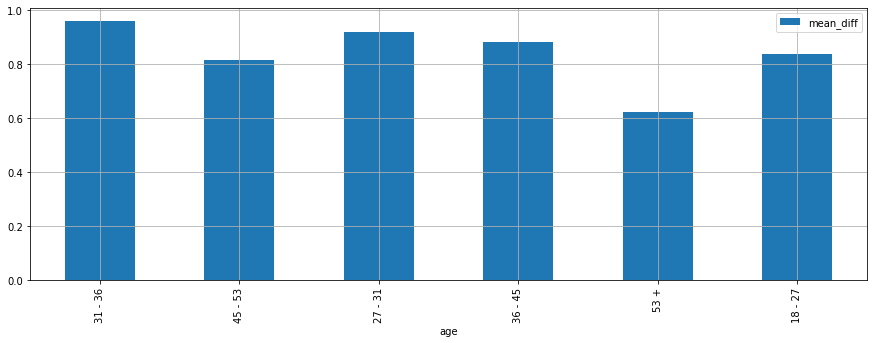

In [ ]:
# plotting the mean difference by age
engagement.groupby('age').apply(mean_col,'avg_diff','mean_diff')[['age','mean_diff']].copy().drop_duplicates().plot.bar(x='age',y='mean_diff',figsize=(15,5),grid=True)

While we observe that none of the age groups have a mean difference superior to one additional transaction after a notification, we also observe that the elderly are much less engaged than other age groups, while the most engaged users are the ones between 27 and 36 years. It also appears that no age group got a negative mean difference (less transactions after a notification).

The following exploration would be with the crypto_unlocked variable, that shows whether the user unlocked the crypto on his account :

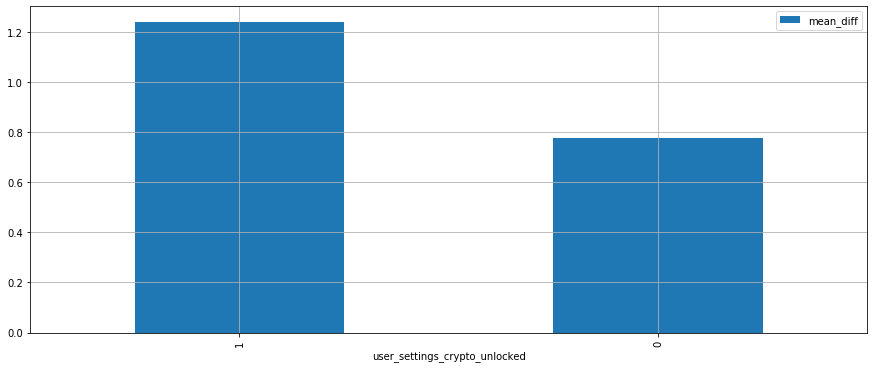

In [ ]:
# plotting the crypto unlocking
engagement.groupby('user_settings_crypto_unlocked').apply(mean_col,'avg_diff','mean_diff')[['user_settings_crypto_unlocked','mean_diff']].copy().drop_duplicates().plot.bar(x='user_settings_crypto_unlocked',y='mean_diff',figsize=(15,6),grid=True)

We can clearly see that users that have unlocked crypto-money on their accounts have much more transactions after each notification they receive.

The following analysis would be about the device brands used by users, with their correlation with the mean difference in transactions.

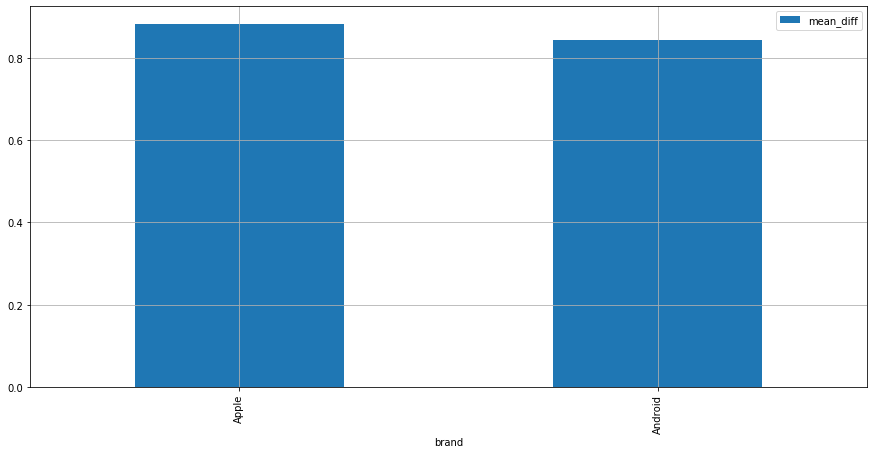

In [ ]:
# plotting the brands
engagement.groupby('brand').apply(mean_col,'avg_diff','mean_diff')[['brand','mean_diff']].copy().drop_duplicates().plot.bar(x='brand',y='mean_diff',figsize=(15,7),grid=True)

We can observe that while Apple user have slightly more transactions after each notification than Android users, the difference is subtle, and they both have less than one transaction on average after each notification.

The next analysis would be about the suscription plan of each user, and its effect on the number of transactions after each notifications :

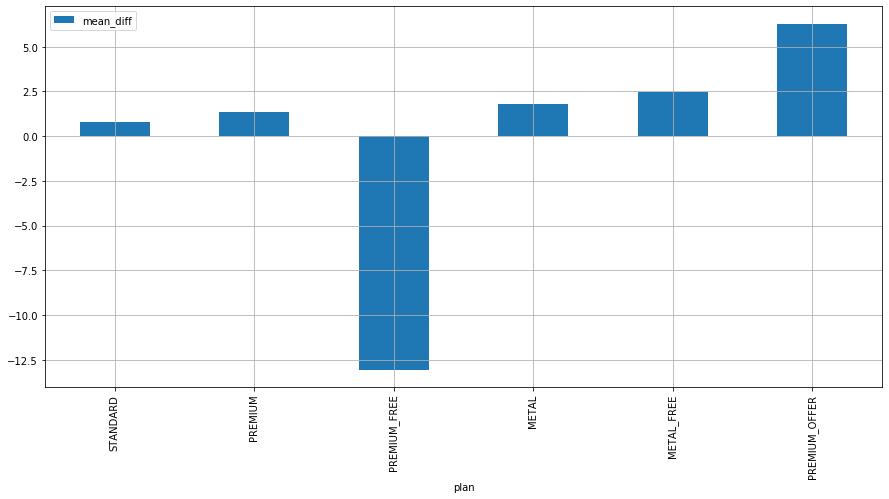

In [ ]:
# plotting the user suscription plan
engagement.groupby('plan').apply(mean_col,'avg_diff','mean_diff')[['plan','mean_diff']].copy().drop_duplicates().plot.bar(x='plan',y='mean_diff',figsize=(15,7),grid=True)

We can clearly see that the plan has a significant effect on the average difference in transactions after notifications, as the **PREMIUM_FREE** offer shows that users with that plan are much sucesptible to have transactions after notifications, while other plans show more engagement from the users, especially on the **PREMIUM_OFFER** plan.

We will next analyze the effect of the ancientness of the user on his difference in transactions after notifications :

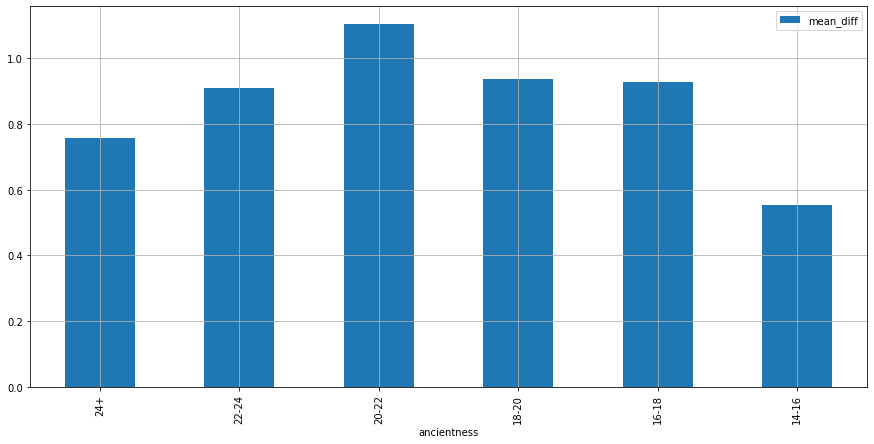

In [ ]:
# plotting the user ancientness
engagement.groupby('ancientness').apply(mean_col,'avg_diff','mean_diff')[['ancientness','mean_diff']].copy().drop_duplicates().plot.bar(x='ancientness',y='mean_diff',figsize=(15,7),grid=True)

We observe an increase in the number of transactions after notifications, for users with an ancientness between 22 and 18 months, that begins to go down sharply if the ancientness is less 16 months, which shows the significant effect of the ancientness on our variable.

Our next analysis would be effect of the notification variables : 

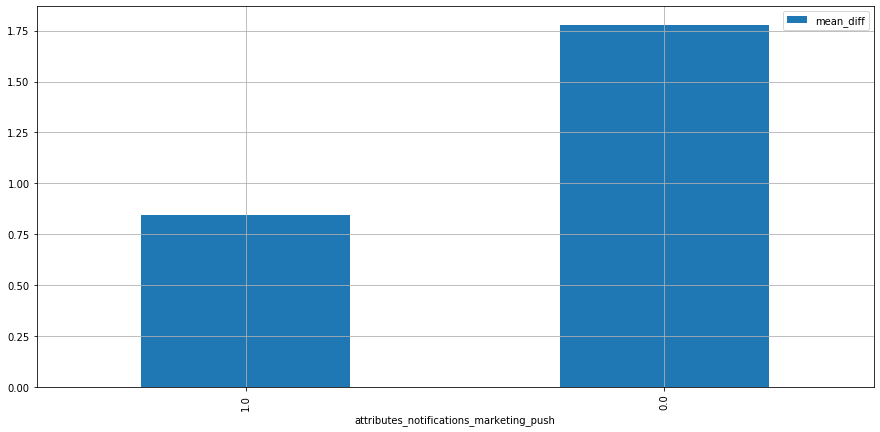

In [ ]:
engagement.groupby('attributes_notifications_marketing_push').apply(mean_col,'avg_diff','mean_diff')[['attributes_notifications_marketing_push','mean_diff']].copy().drop_duplicates().plot.bar(x='attributes_notifications_marketing_push',y='mean_diff',figsize=(15,7),grid=True)

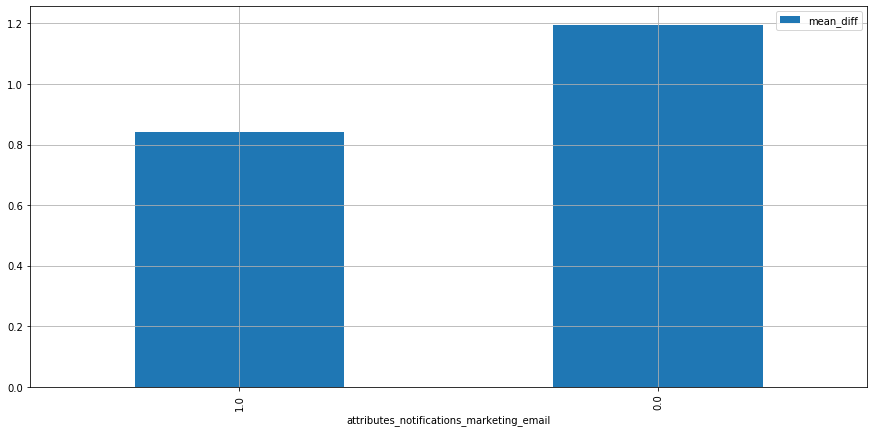

In [ ]:
engagement.groupby('attributes_notifications_marketing_email').apply(mean_col,'avg_diff','mean_diff')[['attributes_notifications_marketing_email','mean_diff']].copy().drop_duplicates().plot.bar(x='attributes_notifications_marketing_email',y='mean_diff',figsize=(15,7),grid=True)

Surprisingly, it appears that users who have not enabled notifications on their accounts, are much more suceptible to have transactions after a notification than the users who activated the notifications.

After exploring the effect of the variables on the mean difference in transactions, we will now analyze the bivariate effect of the variables on it.

We would begin with analysis on the effect of the countries and age groups on our variable :

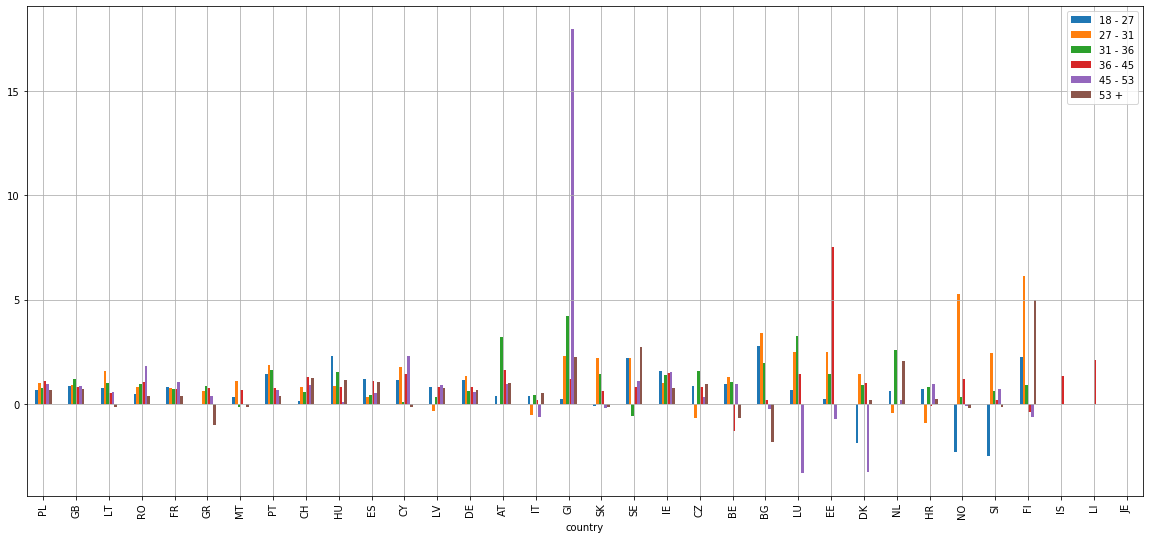

In [ ]:
# creating a cross table with the values of the average difference, depending on the country and age
age_countries_ct = pd.crosstab(engagement.country,engagement.age,values=engagement['avg_diff'],margins=False,aggfunc='mean')

# Setting up the data formats
countries_final = engagement[['country']].merge(age_countries_ct,how='inner',on='country').drop_duplicates().fillna(0)

# ploting the effect of age and countries on the mean difference
countries_final.plot.bar(x='country',y=['18 - 27', '27 - 31', '31 - 36', '36 - 45', '45 - 53', '53 +'],figsize=(20,9),grid=True)

A few countries (on the left) appear to have some uniformity in the mean difference throughout their distribution of ages, while some in the right have big differences in engagement, with sharp increases or decreases depending on the country and the age group. The effect of the age and country appear significant on our variable.

The next analysis would be about the effect of crypto activation and countries on the mean difference :

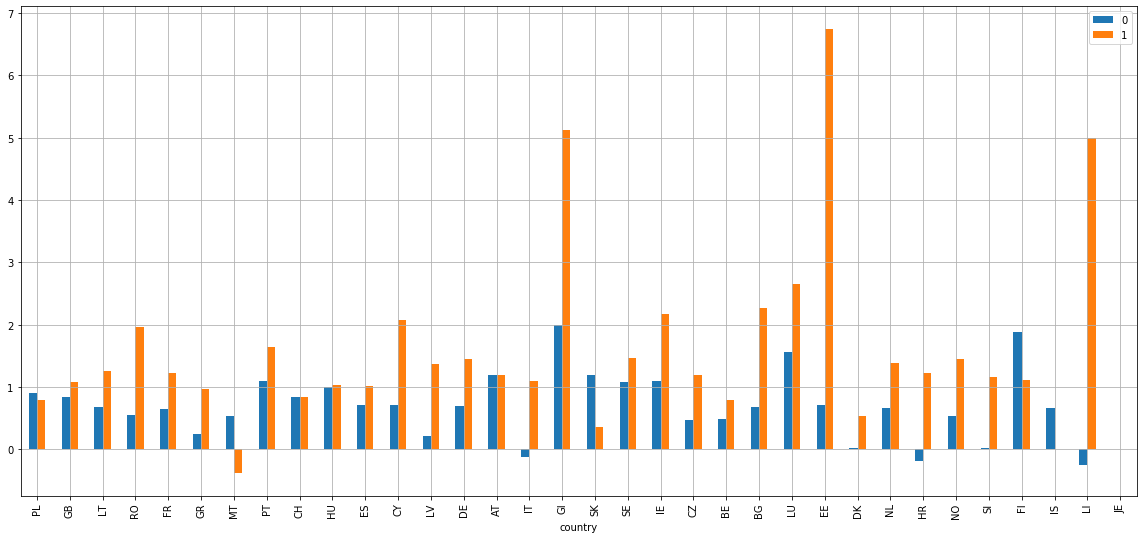

In [ ]:
# creating a cross table with the values of the average difference, depending on the country and crypto activation
country_crypto_ct = pd.crosstab(engagement.country,engagement.user_settings_crypto_unlocked,values=engagement['avg_diff'],margins=False,aggfunc='mean')

# Setting up the data formats
countries_crypto = engagement[['country']].merge(country_crypto_ct,how='inner',on='country').drop_duplicates().fillna(0).reset_index()

# plotting the effect of countries and crypto on the mean difference
countries_crypto.plot.bar(x='country',y=[0,1],figsize=(20,9),grid=True)

It appears clearly that in all countries, users who have activated crypto-money on their accounts make much more transactions after a notifications than the one who didn't, with only a few exceptions.

The next analysis would be about the effect of the plan suscription of the user and his ancientness, on the mean difference :

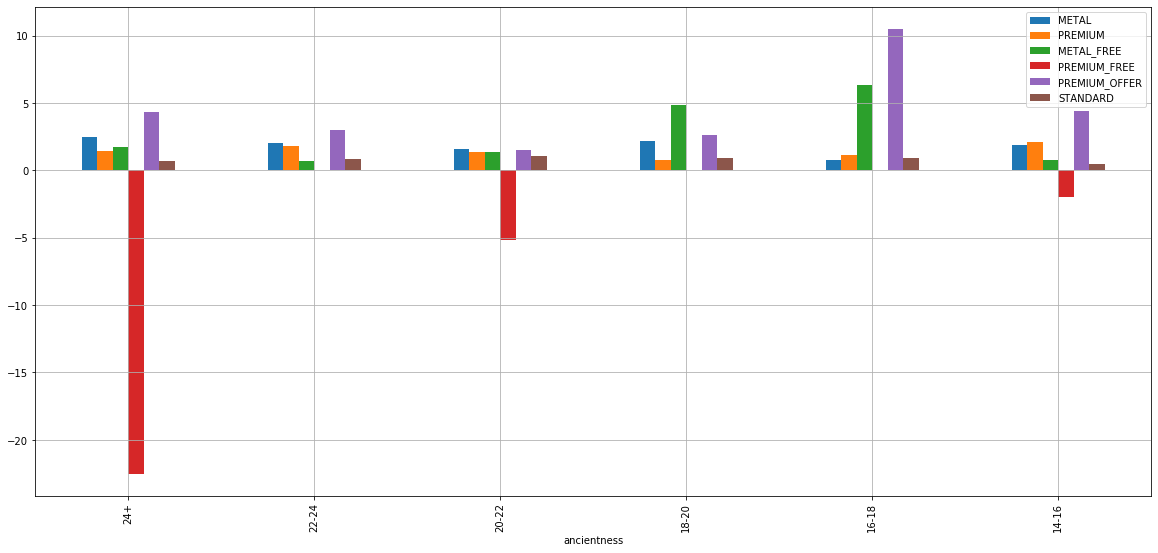

In [ ]:
# creating a cross table with the values of the average difference, depending on the ancientness and suscription plan
ancient_plan_ct = pd.crosstab(engagement.ancientness,engagement.plan,values=engagement['avg_diff'],margins=False,aggfunc='mean')

# setting up the data
ancient_plan = engagement[['ancientness']].merge(ancient_plan_ct,how='inner',on='ancientness').drop_duplicates().reset_index()

# plotting ancientness and user plan and their effect on the mean difference in transactions
ancient_plan.plot.bar(x='ancientness',y=['METAL','PREMIUM','METAL_FREE','PREMIUM_FREE','PREMIUM_OFFER','STANDARD'],figsize=(20,9),grid=True)

The mean difference in transactions appear to be consistently on a decrease in all ancientness categories in the **PREMIUM_FREE** plan, which show its effect on user engagement. The mean difference also  differs quite a bit in each plan, depending on the amount of ancientness.

The previous analysis shows the effects of our variables on the mean difference in transactions before and after a notification.

In the next part, we would attempt to set an exact metric for user engagement.

##### <a name="IV">**IV - User Engagement Metric**</a>
In this phase, we will set up an exact engagement metric, and add it to our dataset for each user.

We will define the engagement metric using the mean difference in transactions 7 days before a notification and 7 days after a notification, by considering each user that has, on average, less than an additional transaction after the notification than before it, as unengaged.

That is in the goals of classifying users depending on their engagement, as the ones that cannot consistently make at least one additional transaction after a notification can be considered as unengaged and in need for engagement procedures.

We will set up as follow the engagement metric in our dataset.

We would begin by defining a threshold of engagement in the mean difference :

In [ ]:
# setting up the engagement threshold
engagement_threshold = 1

Our next step is to create a helper function to encode our mean difference into two categories : engaged (1) and unengaged (0), with one hot encoding :

In [ ]:
# one hot encoding the engagement metric
def y_one_hot_encode(row):
  if row['avg_diff'] >= engagement_threshold:
    val = 1
  else:
    val = 0
  return val

We will set afterward our engagement metric and add it to our dataset :

In [ ]:
# Adding our engagement metric into the 'y' column
engagement['y']= engagement.apply(y_one_hot_encode,axis=1)

# dropping out the average difference column
engagement = engagement.drop('avg_diff',axis=1)

The next phase would be making simple analytics on the engagement metric.

##### <a name="V">**V - Engagement analysis**</a>
In this phase, we will analyze the effect of the various variables on our engagement metric.


As a start, we will define a helper function that will help us create stacked bars and visualizations of our data :

In [ ]:
# preparing data for stacked bars format
def stack_cols(df, col, new_col,two_new_col):
    df[new_col] = df[df['y']==0].shape[0] / df.shape[0]
    df[two_new_col] = df[df['y']==1].shape[0] / df.shape[0]
    return df

We will now be creating a visualization of the effect of countries on engagement :


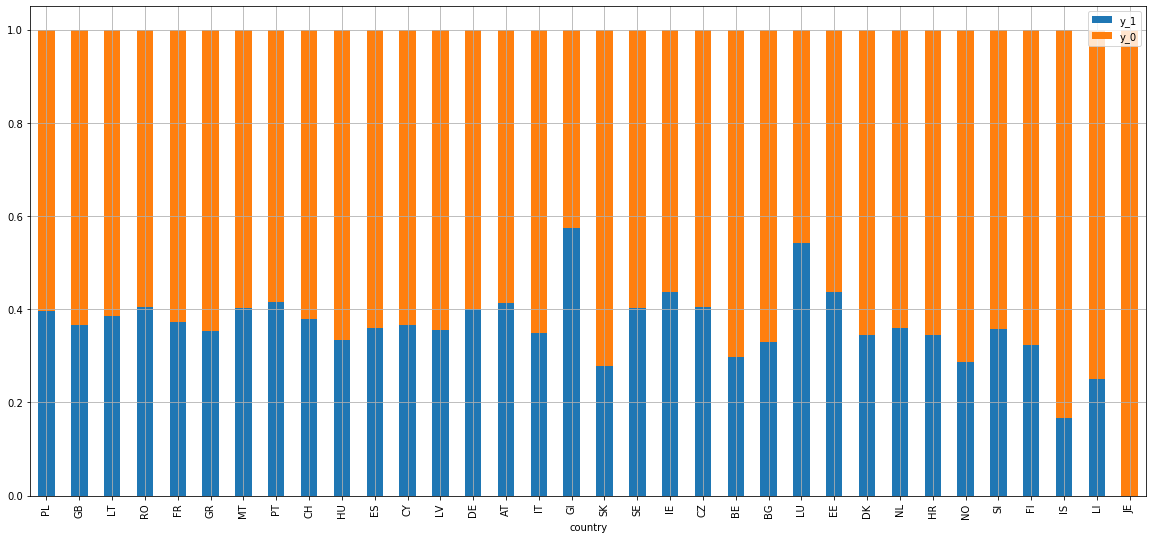

In [ ]:
# creating a countries dataset with percentages of engagement
countries = engagement.groupby('country').apply(stack_cols,'y','y_0','y_1')[['country','y_1','y_0']].drop_duplicates().reset_index()[['country','y_1','y_0']]

# plotting the engagement depending on countries
countries.plot.bar(x='country' ,stacked=True,figsize=(20,9),grid=True)

We apparently see that the amount of engaged users (the blue bars) varies greatly depending on the country of the user.

We will now analyze the amount of engaged users depending on the age of the users :

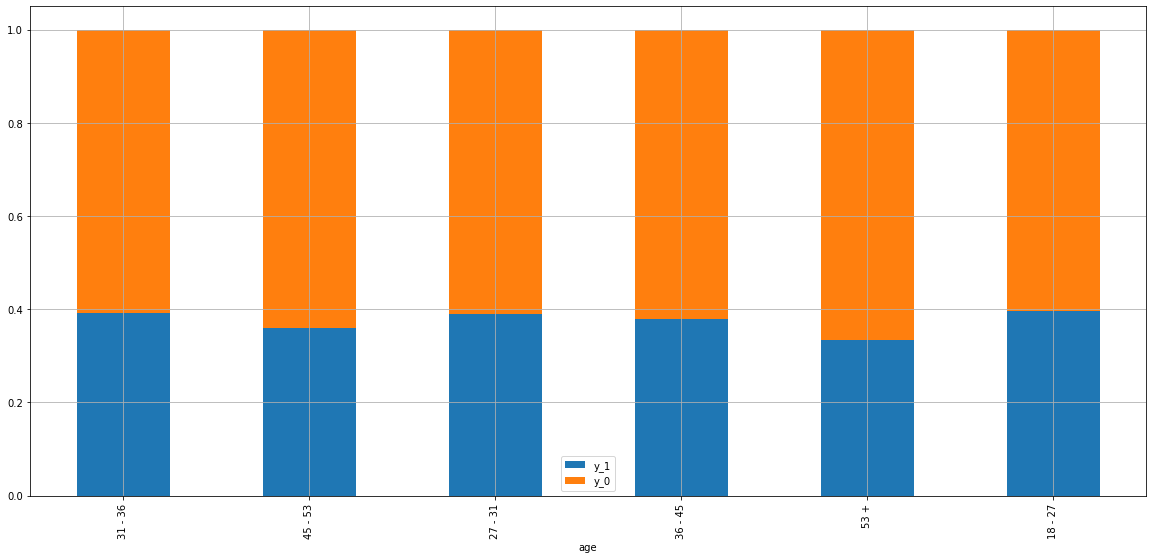

In [ ]:
# creating an age group dataset with percentages of engagement
ages = engagement.groupby('age').apply(stack_cols,'y','y_0','y_1')[['age','y_1','y_0']].drop_duplicates().reset_index()[['age','y_1','y_0']]

# plotting the engagement depending on age groups
ages.plot.bar(x='age' ,stacked=True,figsize=(20,9),grid=True)

We can apparently see that the amount of engaged users varies slightly, depending on the age of the users.

Next is an analysis of the device brands used by users :

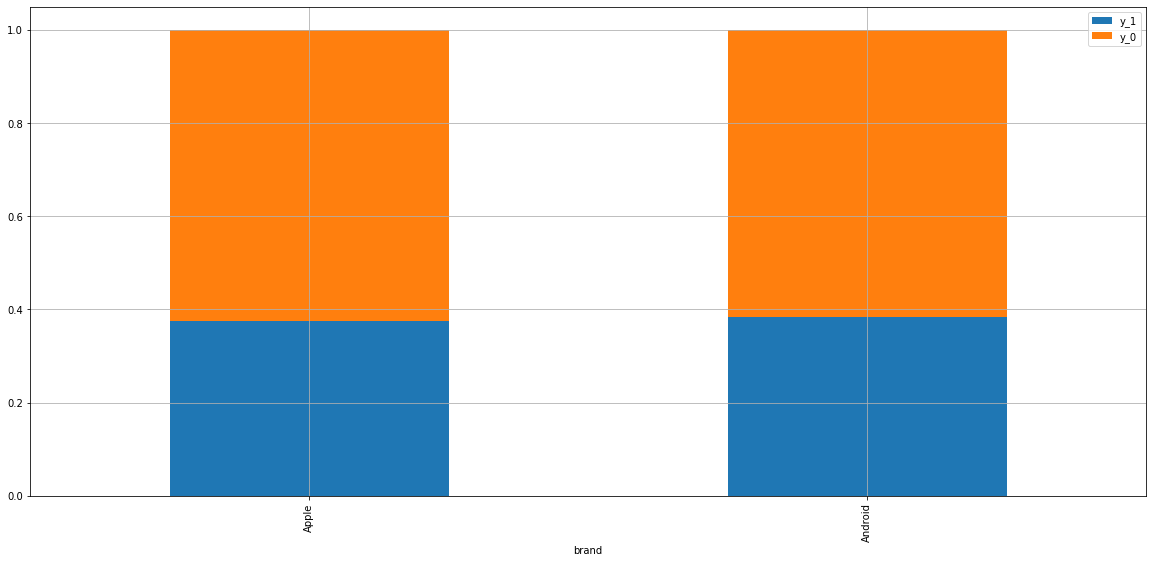

In [ ]:
# creating a brand dataset with percentages of engagement
brands = engagement.groupby('brand').apply(stack_cols,'y','y_0','y_1')[['brand','y_1','y_0']].drop_duplicates().reset_index()[['brand','y_1','y_0']]

# plotting the engagement depending on brands
brands.plot.bar(x='brand' ,stacked=True,figsize=(20,9),grid=True)

It appears that engaged users are distributed equally between the device brands of the users.

Following this is an analysis of the user engagement depending on the plan of the user :

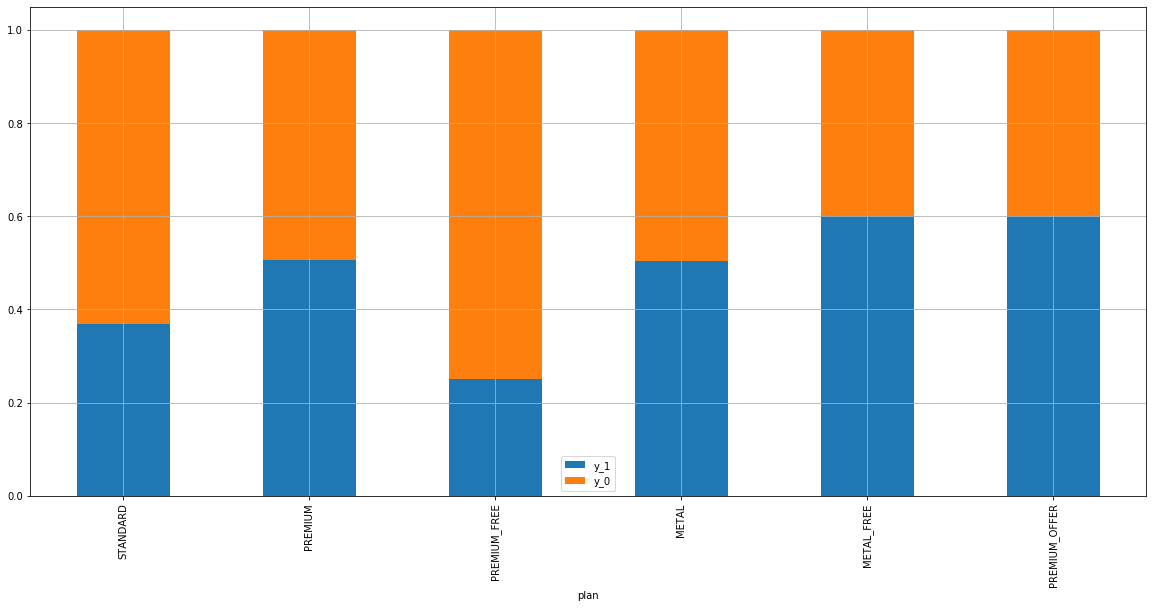

In [ ]:
# creating a user plan dataset with percentages of engagement
plans = engagement.groupby('plan').apply(stack_cols,'y','y_0','y_1')[['plan','y_1','y_0']].drop_duplicates().reset_index()[['plan','y_1','y_0']]

# plotting the engagement depending on user plan
plans.plot.bar(x='plan' ,stacked=True,figsize=(20,9),grid=True)

We can here observe sharp increases and decreases in engagement, depending on the plan of the user, with **PREMIUM_FREE** having the least engaged users, and **METAL_FREE** and **PREMIUM_OFFER** having the most engaged users.

The next analysis would be the amount of engaged users depending on their ancientness :

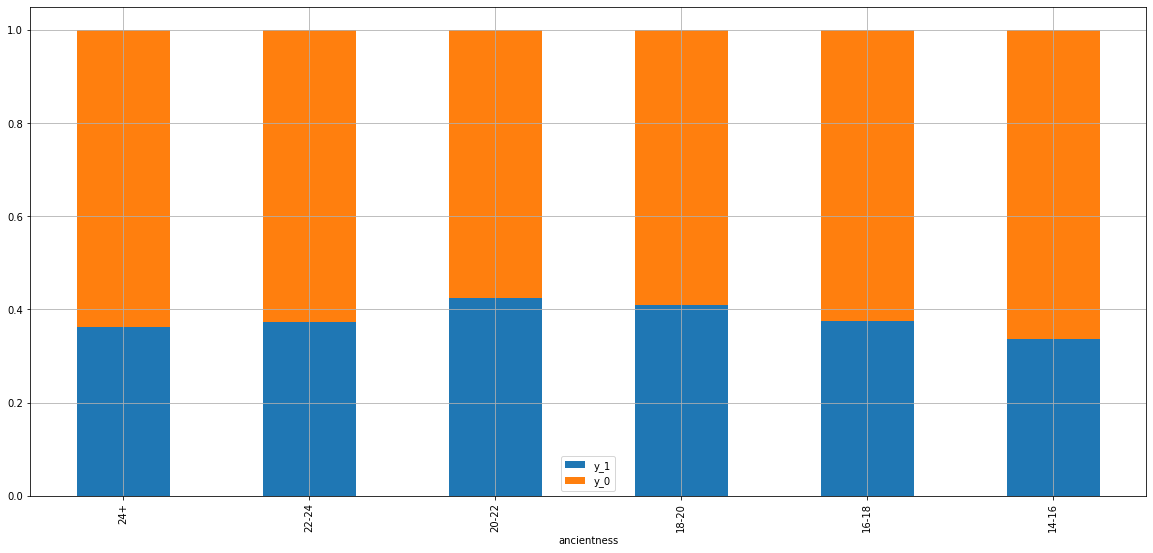

In [ ]:
# creating an ancientness dataset with percentages of engagement
ancientness = engagement.groupby('ancientness').apply(stack_cols,'y','y_0','y_1')[['ancientness','y_1','y_0']].drop_duplicates().reset_index()[['ancientness','y_1','y_0']]

# plotting the engagement depending on ancientness
ancientness.plot.bar(x='ancientness' ,stacked=True,figsize=(20,9),grid=True)

The user engagement varies slightly depending on his ancientness, with the most engaged users being those having between 18 and 22 month of ancientness. 

Our next analysis is the effect of activating notifications on the user engagement :

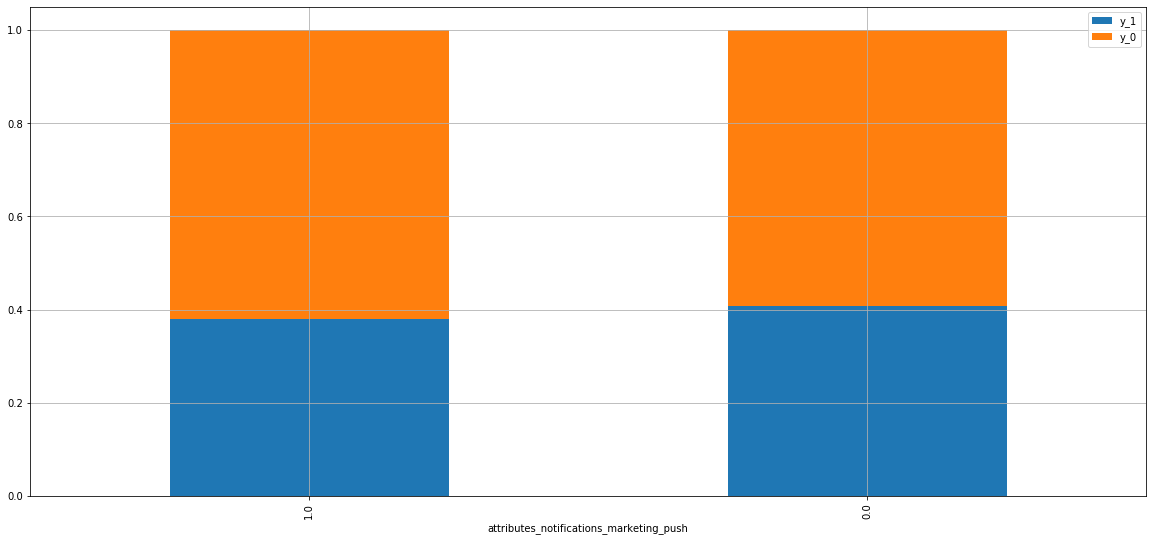

In [ ]:
# creating a notification dataset with percentages of engagement
push = engagement.groupby('attributes_notifications_marketing_push').apply(stack_cols,'y','y_0','y_1')[['attributes_notifications_marketing_push','y_1','y_0']].drop_duplicates().reset_index()[['attributes_notifications_marketing_push','y_1','y_0']]

# plotting the engagement depending on notifications
push.plot.bar(x='attributes_notifications_marketing_push' ,stacked=True,figsize=(20,9),grid=True)

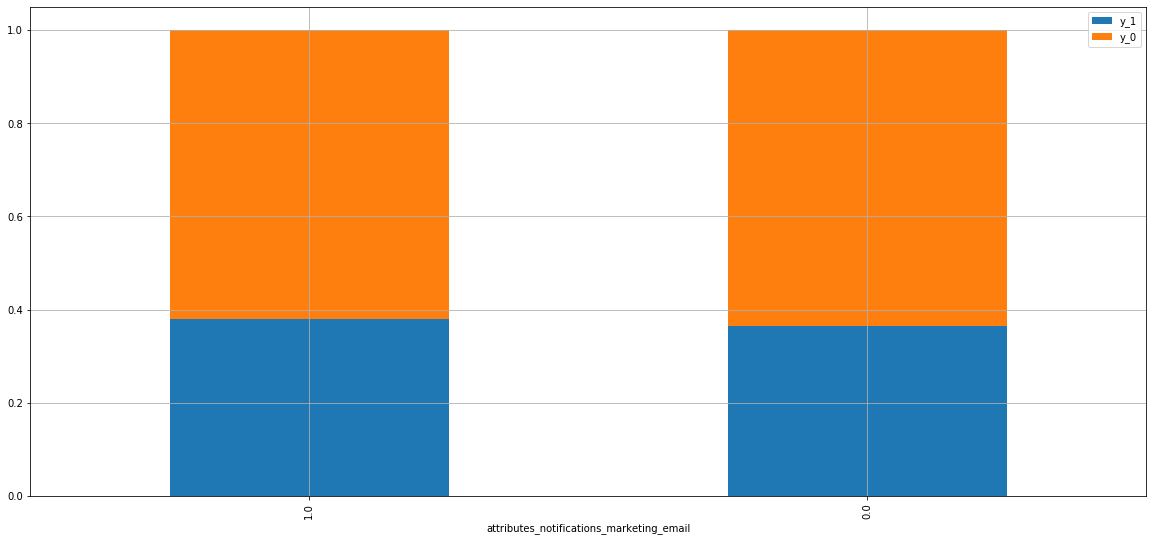

In [ ]:
# creating a notification dataset with percentages of engagement
email = engagement.groupby('attributes_notifications_marketing_email').apply(stack_cols,'y','y_0','y_1')[['attributes_notifications_marketing_email','y_1','y_0']].drop_duplicates().reset_index()[['attributes_notifications_marketing_email','y_1','y_0']]

# plotting the engagement depending on notifications
email.plot.bar(x='attributes_notifications_marketing_email' ,stacked=True,figsize=(20,9),grid=True)

There appears to be a slight effect of notifications on user engagement.

The next analysis would be about the effect of crypto activation on user engagement :

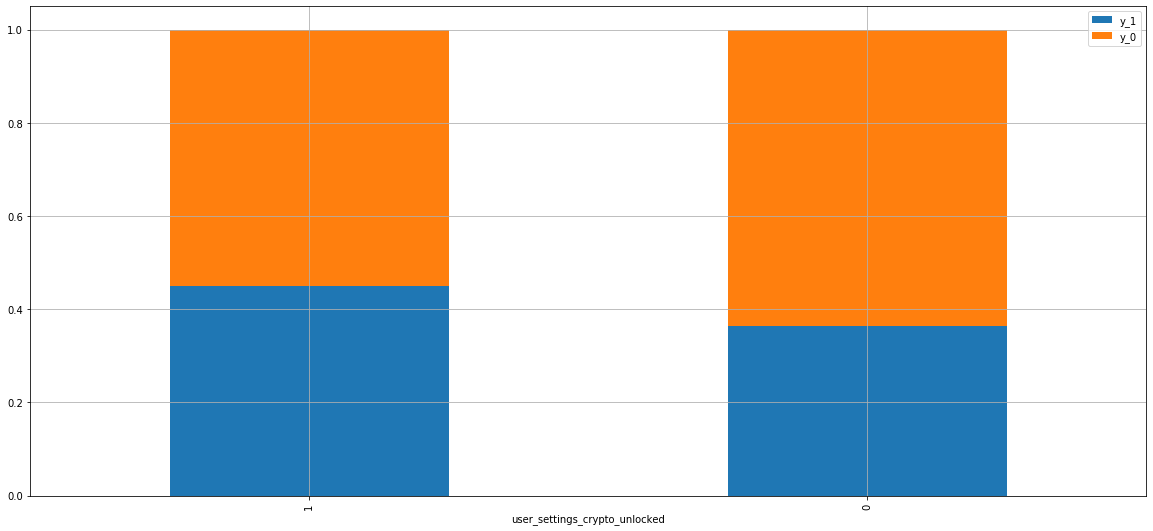

In [ ]:
# creating a crypto dataset with percentages of engagement
crypto = engagement.groupby('user_settings_crypto_unlocked').apply(stack_cols,'y','y_0','y_1')[['user_settings_crypto_unlocked','y_1','y_0']].drop_duplicates().reset_index()[['user_settings_crypto_unlocked','y_1','y_0']]

# plotting the engagement depending on crypto activation
crypto.plot.bar(x='user_settings_crypto_unlocked' ,stacked=True,figsize=(20,9),grid=True)

We can see that users that unlocked crypto are much more likely to be engaged.

After this study, it is observable that our engagement metric enables us to classify our users depending on their amount of engagement.


---
#### <a name="3">**Part 3 :** *Build an engagement classification model*</a>

We will begin by preparing data for usage in models, and then we will try various machine learning  models to find the most effective and practical one for our classification goals.

##### <a name="data">**I - Data preparation**</a>

We will begin to prepare our data for usage in a classification model.

The dataset we'll be using is the engagement dataset we have prepared through the precedent question. A quick peak through it shows the following :

In [ ]:
engagement.head()

,user_id,country,age,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,brand,ancientness,y
0,user_0,PL,31 - 36,1,STANDARD,1.0,1.0,Apple,24+,1
1,user_1,GB,45 - 53,0,STANDARD,1.0,1.0,Apple,24+,1
2,user_5,LT,27 - 31,1,STANDARD,1.0,1.0,Apple,24+,0
3,user_6,GB,36 - 45,0,STANDARD,1.0,1.0,Apple,24+,0
4,user_7,RO,31 - 36,0,STANDARD,1.0,1.0,Apple,24+,0


We will begin by studying the correlations between variables :

In [ ]:
# pearson correlations between variables
engagement.corr(method='pearson')

,user_settings_crypto_unlocked,attributes_notifications_marketing_push,attributes_notifications_marketing_email,y
user_settings_crypto_unlocked,1.000000,-0.029376,-0.012777,0.068067
attributes_notifications_marketing_push,-0.029376,1.000000,0.471580,-0.008361
attributes_notifications_marketing_email,-0.012777,0.471580,1.000000,0.007806
y,0.068067,-0.008361,0.007806,1.000000


There appears to be a high correlation between **attributes_notifications_marketing_push** and **attributes_notifications_marketing_email**. In order to avoid the overfitting of our model, we will be dropping **attributes_notifications_marketing_email** variable as follows :

In [ ]:
# dropping notification_email variable
engagement = engagement.drop('attributes_notifications_marketing_email',axis=1)

Next, we will start one hot encoding our variables in order to make them ready for usage in our coming model. 

We would start with one hot encoding all our variables :

In [ ]:
# One hot encoding categorical varialbles
one_hot_country = pd.get_dummies(engagement['country'])
one_hot_ancientness = pd.get_dummies(engagement['ancientness'])
one_hot_brand = pd.get_dummies(engagement['brand'])
one_hot_age = pd.get_dummies(engagement['age'])
one_hot_plan = pd.get_dummies(engagement['plan'])

Then drop their initial columns on our dataset :

In [ ]:
# dropping categorical variables from engagement dataset
engagement = engagement.drop('country', axis=1)
engagement = engagement.drop('ancientness', axis=1)
engagement = engagement.drop('brand', axis=1)
engagement = engagement.drop('age', axis=1)
engagement = engagement.drop('plan', axis=1)


Afterward, we would join our one hot encoded variables with our engagement dataset :

In [ ]:
# Adding one hot encoded categorical variables
engagement = engagement.join(one_hot_country)
engagement = engagement.join(one_hot_ancientness)
engagement = engagement.join(one_hot_brand)
engagement = engagement.join(one_hot_age)
engagement = engagement.join(one_hot_plan)

A peak at our dataset shows us the following :

In [ ]:
print("Number of users : {:1d} user\nEach user defined by {:1d} variable".format(engagement.shape[0],engagement.shape[1]))

Number of users : 16855 user
Each user defined by 58 variable


In [ ]:
engagement.head()

,user_id,user_settings_crypto_unlocked,attributes_notifications_marketing_push,y,AT,BE,BG,CH,CY,CZ,DE,DK,EE,ES,FI,FR,GB,GI,GR,HR,HU,IE,IS,IT,JE,LI,LT,LU,LV,MT,NL,NO,PL,PT,RO,SE,SI,SK,14-16,16-18,18-20,20-22,22-24,24+,Android,Apple,18 - 27,27 - 31,31 - 36,36 - 45,45 - 53,53 +,METAL,METAL_FREE,PREMIUM,PREMIUM_FREE,PREMIUM_OFFER,STANDARD
0,user_0,1,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,user_1,0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1
2,user_5,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1
3,user_6,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1
4,user_7,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1


We will save the resulting model, for usage in the machine learning part.

In [ ]:
engagement.to_csv('data/rev-ml.csv')

The next phase would be about preparing models for engagement classification.

##### <a name="ml">**II - Classification Model**</a>
We would be building in this phase various classification models, to test their effectiveness and precision in this task, and choose the most optimal one for our concerns. We will be experimenting with Logistic regression, Support Vector machines, K-nearest neighbors and random forests.



First we would import our machine learning prepared dataset, and import some necessary libraries :

In [ ]:
# Importing libraries
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier

# Importing the prepared machine learning dataset
engagement = pd.read_csv('data/rev-ml.csv').drop('Unnamed: 0',axis=1)

Then we will separate our variables into two separate dataframes :

In [ ]:
# creating y, the ground value variable
y = engagement['y']

# preparing the dependant variables
X = engagement.drop('y', axis=1)
X = X.drop('user_id',axis=1)

An exploration of our 'y' variable shows :

In [ ]:
y.value_counts()

0    10450
1     6405
Name: y, dtype: int64

The unengaged users are much more numerous than engaged ones, which creates a slight unbalance in our dataset, that we would need to factor in our models.

Then we would split data for training and testing separately (70% training, 30% test), so that are our model can be generalized and used on new data.

In [ ]:
# Splitting test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

###### <a name="a">*Logistic Regression*</a>

We will begin with implementing a logistic regression on our data. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable. 



We will create our model, and train it using our training data :

In [ ]:
# creating the model, with weights for the unbalanced dataset
logreg = LogisticRegression(max_iter=1000,random_state=6,class_weight={1:1.35,0:0.9})

# training the model
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.9, 1: 1.35}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=6, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We will next be testing its accuracy on the test data we split earlier :

In [ ]:
# Making predictions on test data
y_pred = logreg.predict(X_test)

# printing accuracy of predictions
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.58


The accuracy of our model on our data is 58%. The label counts appear to be unbalanced, with unengaged users being much more than engaged users, so accuracy isn't a very reliable metric in this situation. For that reason, we will create a confusion matrix to analyze the results.

In [ ]:
# creating confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[2194  939]
 [1188  736]]


A view of the confusion matrix shows that the model recognizes many values as True negatives, a few as true positives, but with numerous entries on False positives and false negatives.

Below appears a classification report, with the recall and precision of each class. As it is apparent, our model got 70% of the existing unengaged users, and had a precision of 65%. It remains lacking in terms of recall and precision for the engaged class, capturing only 38% of the engaged users, with only 44% precision on the class.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.70      0.67      3133
           1       0.44      0.38      0.41      1924

    accuracy                           0.58      5057
   macro avg       0.54      0.54      0.54      5057
weighted avg       0.57      0.58      0.57      5057



###### <a name="b">*Support Vector Machine*</a>

We will try next support vector machine for classification. A support vector machine (SVM) is a supervised machine learning model that uses classification algorithms for two-group classification problems.

We will begin by creating the model, training it, and making predictions on our test dataset.

In [ ]:
# creating svm model with an rbf kernel
clf = svm.SVC(kernel='rbf')

# training the svm model
clf.fit(X_train, y_train)

# making predictions on the test data with the svm model
y_pred = clf.predict(X_test)

# priting the accuracy of the svm model
print('Accuracy of svm classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of svm classifier on test set: 0.62


The overall accuracy of our SVM model is 62%. We will now observe the other metrics.

In [ ]:
# creating the confusion matrix of the testing
confusion = confusion_matrix(y_test, y_pred)

# priting information about the model
print("Confusion matrix for the SVM model on test data :")
print(confusion)
print("SVM Classification report :")
print(classification_report(y_test, y_pred))

Confusion matrix for the SVM model on test data :
[[3040   93]
 [1848   76]]
SVM Classification report :
              precision    recall  f1-score   support

           0       0.62      0.97      0.76      3133
           1       0.45      0.04      0.07      1924

    accuracy                           0.62      5057
   macro avg       0.54      0.50      0.42      5057
weighted avg       0.56      0.62      0.50      5057



We observe that our model captures 97% of the unnengaged users, and has a precision of detecting them of 62%. Nevertheless, it could only capture 4% of the engaged users, with a precision of 45%, which brought out a high number of false negatives.

###### <a name="c">*K-Nearest Neighbors*</a>

We will now work on implementing a K-nearest neighbors model. The KNN model is a supervised machine learning for regression and classifications tasks, that projects observations in a vectorial space, and computes distances between them to find the nearest neighborhood for prediction.

We begin by implementing and testing the KNN model on our data

In [ ]:
# creating the knn model
knn = neighbors.KNeighborsClassifier(n_neighbors=9,weights='distance')

# training the knn model
knn.fit(X_train, y_train)

# making predictions on the test data
y_pred = knn.predict(X_test)

# printing accuracy of the model
print('Accuracy of knn model on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of knn model on test set: 0.58


In [ ]:
# generating confusion matrix of the model
confusion = confusion_matrix(y_test, y_pred)

# printing information about model performance
print("Confusion matrix for the KNN model on test data :")
print(confusion)
print("KNN Classification report :")
print(classification_report(y_test, y_pred))

Confusion matrix for the KNN model on test data :
[[2464  669]
 [1478  446]]
KNN Classification report :
              precision    recall  f1-score   support

           0       0.63      0.79      0.70      3133
           1       0.40      0.23      0.29      1924

    accuracy                           0.58      5057
   macro avg       0.51      0.51      0.50      5057
weighted avg       0.54      0.58      0.54      5057



The model captures 79% of the unnengaged users, with a precision of their recognition as unnengaged of 63%. On the other hand, it captures 23% of engaged users in our dataset, with a precision of 40%.

###### <a name="d">*Random Forest* </a>

Our next model is a random forest. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class predicted by the majority of the trees at inference time.

We begin by implementing the model and testing its accuracy.



In [ ]:
# Creating the random forest model
randomforest = RandomForestClassifier(n_estimators=5)

# training the random forest model
randomforest.fit(X_train, y_train)

# testing the model on testing data
y_pred = randomforest.predict(X_test)

# printing out accuracy of the model
print('Accuracy of random forest classifier on test set: {:.2f}'.format(randomforest.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.58


We build a confusion matrix for our model to analyze it further :

In [ ]:
# generating confusion matrix for the model
confusion = confusion_matrix(y_test, y_pred)

# printing out the model performance data
print("Confusion matrix for the Random Forest model on test data :")
print(confusion)
print("Random Forest Classification report :")
print(classification_report(y_test, y_pred))

Confusion matrix for the Random Forest model on test data :
[[2441  692]
 [1429  495]]
Random Forest Classification report :
              precision    recall  f1-score   support

           0       0.63      0.78      0.70      3133
           1       0.42      0.26      0.32      1924

    accuracy                           0.58      5057
   macro avg       0.52      0.52      0.51      5057
weighted avg       0.55      0.58      0.55      5057



Our model captures 78% of the unnengaged users in the dataset, with a precision of 63%. The recall is though only 26% for engaged users, with precision of 42%.

###### <a name="e">*Final Model choice* </a>

The four machine learning models bring out some slightly differing results. 

As we're trying to reduce churn, we aim to capture the highest number of unnengaged users in our model. For that, the Support vector machine model appears to be the best one. Nevertheless, we make the hypothesis that reengaging each unnengaged user costs for the company, and that is reason for maximizing precision and recall for engaged users too, to minimize the number of false negatives.

The logistic regression model, after adding weights, appear to be the middle ground of both goals, with a good recall and precision for unnengaged users, and a moderate recall and precision for engaged users. That is the reason we'll be choosing that model for our task.

---
#### <a name="4">**Part 4 :** *Churn reduction*</a>
We assume that an unengaged user is a churned user, and that we use our chosen model to identify unengaged users and implement business actions to try to convert them to engaged users. 

We will conduct some A/B testing to experiment and check the effect of our business action on churn reduction, and then we'll perform a statistical test to gauge whether the reduction was due to chance or our actions.

To explain further, we would begin by choosing two statistically significant populations of identified unengaged users, that have similar conditions (crypto, plan, ancientness, etc). We would then peform our business actions on one of the two populations.

Our null hypothesis states afterward that any difference between the two populations is due to chance. The negation of the hypothesis would make our business actions having a significant effect on user re-engagement. 

To achieve that, we will perform a t-test, on the average difference of transactions before and after receiving notifications. If the p-value ends up showing that there is statistical significance and that the change in average difference of amount of transactions is not due to chance, that would validate the effect of our business action.